<a href="https://colab.research.google.com/github/HenryRandall/precinct_creator/blob/main/precinct_creator_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygris

In [2]:
# https://geopandas.org/en/stable/docs.html
import pandas as pd
import geopandas as gpd
import statistics
import pygris
from itertools import combinations

# Import Custom Fuctions
from functions.geolocation_filter import geolocation_filter
from functions.overlap_resolver import overlap_resolver

# Silence warning from pandas, it is a known bug that it is called too frequently
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Set Variables
stdev_from_mean = 3 #Standard Deviation of Data Point Removed Immediatly
state = 'GA' #State you are working in
county = 'Gwinnett' #County you are working in
step_size = 0.02 #Size of buffer added to precincts to expand them
threshhold = 0.99999 #Area of county covered needed to stop expanding
removal_thresh = 1E-3 #Threshold to find polygons small enough from precinct shape,this is multiplied by the mean area of polygons
geolocated_error_thresh = 0.01 #percent of points in a precinct needed in a cluster to stay valid, 0.001 is 0.1%. tried 0.001 and 0.005 and both let in outliers

In [4]:
# Get the shapefile for a specific state (e.g., Georgia), Convert to same mercatur CRS to start and merge into a state shape
counties_gpd = pygris.counties(state=state)
counties_gpd = counties_gpd.to_crs('EPSG:4326')
state_shape = counties_gpd.union_all()

Using the default year of 2021
Using FIPS code '13' for input 'GA'


In [5]:
# Load in Data and Drop NAs
voter_file = pd.read_excel('/content/lat_long.xlsx')
voter_file = voter_file.dropna(subset=['Latitude'])
voter_file = voter_file.dropna(subset=['Longitude'])
voter_file = voter_file.dropna(subset=['PrecinctName'])

# Convert crs and clip anything coming up outside of the state
voter_file = gpd.GeoDataFrame(voter_file, geometry=gpd.points_from_xy(voter_file.Longitude, voter_file.Latitude), crs="EPSG:4326")
voter_file = gpd.clip(voter_file, state_shape)

# Create New column of county names based on precinct names
voter_file['CountyName'] = voter_file['PrecinctName'].str.split(' - ').str.get(0)

In [6]:
# Loading in County Specific dfs, and make list of precinct names
voter_file_county = voter_file.loc[voter_file['CountyName'].isin([county])]
precinct_names = sorted(voter_file_county['PrecinctName'].unique())
# use mean lat and long to create a non-mercatur crs
mean_county_lon = statistics.mean(voter_file_county['Longitude'])
mean_count_lat = statistics.mean(voter_file_county['Latitude'])
crs = f'+proj=cea +lat_0={mean_count_lat} +lon_0={mean_county_lon} +units=mi'
# Pull county shape and convert shape and points to non-mercatur crs, then clip anything outside the county
county_shape = counties_gpd.loc[counties_gpd['NAME'].isin([county])].to_crs(crs).geometry.iloc[0]
voter_file_county = voter_file_county.to_crs(crs)
voter_file_county = gpd.clip(voter_file_county, county_shape)

Current Precinct Filtering and Creation Module - Concave Hull



In [7]:
# Base Precinct Creations
precinct_list = []

for precinct_name in precinct_names:
  # Prep Precinct Data
  voter_file_precinct = voter_file_county.loc[voter_file_county['PrecinctName'].isin([precinct_name])]
  voter_file_precinct = voter_file_precinct.drop_duplicates(subset=['Latitude', 'Longitude'])
  voter_file_precinct = voter_file_precinct.reset_index(drop=True)

  # k nearest neighbors filter, check functions for details
  voter_file_precinct_filtered = geolocation_filter(voter_file_precinct, geolocated_error_thresh, stdev_from_mean, crs)

  # Refilter until nothing is removed - I used to only let it fire a maximum of 2 times, it was more accurate then. Currently removing too much
  row_change = len(voter_file_precinct.index) - len(voter_file_precinct_filtered.index)
  while row_change > 0:
    row_start = len(voter_file_precinct_filtered.index)
    voter_file_precinct_filtered = geolocation_filter(voter_file_precinct_filtered, geolocated_error_thresh, stdev_from_mean, crs)
    row_change = row_start - len(voter_file_precinct_filtered.index)

  # Create hulls
  multipoint = voter_file_precinct_filtered.dissolve()
  hull = multipoint.concave_hull()
  precinct_list.append({'PrecinctName': precinct_name, 'geometry': hull[0]})

precinct_df = gpd.GeoDataFrame(precinct_list, geometry='geometry', crs=crs)

<Axes: >

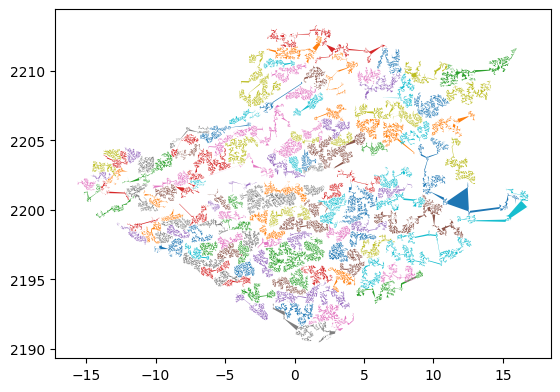

In [8]:
precinct_df.plot(column='PrecinctName', legend=False)

Ideas to maybe Improve:

2.   Precincts fight over areas based on how many people are correctly placed there

Expansion Module

(156, 2)
(156, 2)
0.18412462888773448
(156, 2)
0.38386534676777984
(156, 2)
0.4820036250667036
(156, 2)
0.5492892359845541
(156, 2)
0.6029495973427315
(156, 2)
0.6478341481310649
(156, 2)
0.686280658840361
(156, 2)
0.7199630363391817
(156, 2)
0.7492171573335357
(156, 2)
0.7749212553552564
(156, 2)
0.7975539747517446
(156, 2)
0.8177827657551365
(156, 2)
0.8356070952348414
(156, 2)
0.8515458675478216
(156, 2)
0.8659557257852848
(156, 2)
0.8787217453414208
(156, 2)
0.8904814791410609
(156, 2)
0.9009063847160934
(156, 2)
0.9107725584747697
(156, 2)
0.919638181833153
(156, 2)
0.9275212131554473
(156, 2)
0.934762028726545
(156, 2)
0.94115922338108
(156, 2)
0.9469439718616225
(156, 2)
0.9521112875352454
(156, 2)
0.9566585965649415
(156, 2)
0.9608425645957398
(156, 2)
0.9646105619139866
(156, 2)
0.9679179843591716
(156, 2)
0.9709489858549619
(156, 2)
0.9735194531664194
(156, 2)
0.9758590810699755
(156, 2)
0.977967330928815
(156, 2)
0.9796928697795824
(156, 2)
0.9812861117786207
(156, 2)
0.9826

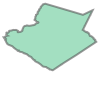

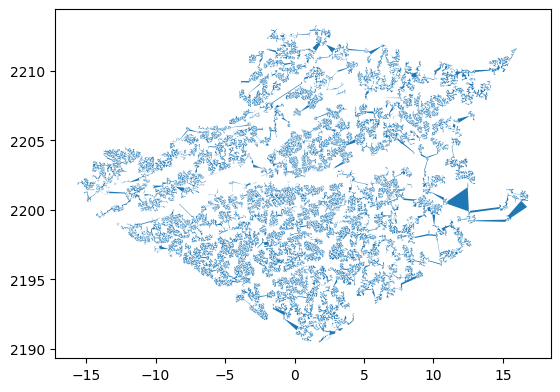

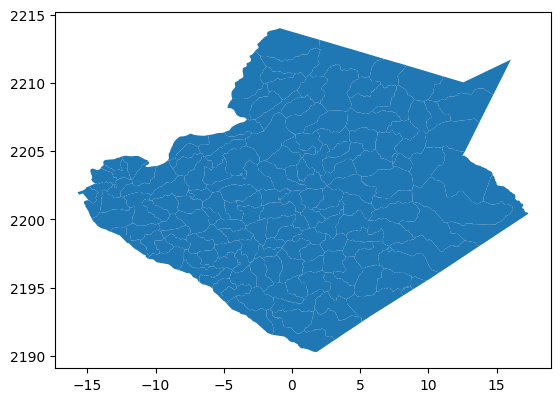

In [9]:
# New Expansion Module
# Remove Overlaps in original creator
precinct_df_3=precinct_df.copy()
precinct_df_3['geometry'] = precinct_df_3['geometry'].to_crs(crs)
print(precinct_df_3.shape)
poly = precinct_df_3.geometry
for p1_idx, p2_idx in combinations(poly.index, 2):
    if poly.loc[p1_idx].overlaps(poly.loc[p2_idx]):
        # Store intermediary results back to poly
        poly.loc[p1_idx], poly.loc[p2_idx] = overlap_resolver(poly.loc[p1_idx],poly.loc[p2_idx])
precinct_df_3['geometry'] = poly
precinct_df_3 = precinct_df_3.explode()
precinct_df_3 = precinct_df_3[precinct_df_3.geometry.geom_type != 'LineString']
precinct_df_3['area']=precinct_df_3.geometry.area
precinct_df_3 = precinct_df_3[precinct_df_3['area'] > precinct_df_3['area'].mean()*removal_thresh]
precinct_df_3 = precinct_df_3.drop(['area'],axis=1)
precinct_df_3 = precinct_df_3.dissolve(by='PrecinctName')
precinct_df_3 = precinct_df_3.reset_index()


# Loop until hitting minimum coverage
while precinct_df_3.geometry.union_all().area < (county_shape.area)*threshhold:
  print(precinct_df_3.shape)
  print(precinct_df_3.geometry.union_all().area/(county_shape.area))
  # Simplify to make sure that it isnt getting increasingly complex
  precinct_df_3['geometry'] = precinct_df_3.simplify(step_size).make_valid()
  precinct_df_expanded = precinct_df_3.copy()
  # Expand by one step to eat out unassigned land
  precinct_df_expanded.geometry = precinct_df_expanded.geometry.buffer(step_size)

  # Cut out any additions that were part of a different precincts original hull
  poly_orig = precinct_df_3.geometry
  poly_expand = precinct_df_expanded.geometry
  for p1_idx, p2_idx in combinations(poly_orig.index, 2):
    try:
      if poly_expand.loc[p1_idx].boundary.intersects(poly_expand.loc[p2_idx].boundary):
        poly_expand.loc[p1_idx] -= poly_orig.loc[p2_idx]
        poly_expand.loc[p2_idx] -= poly_orig.loc[p1_idx]
    except:
      precinct_df_expanded['geometry'] = poly_expand
      precinct_df_expanded = precinct_df_expanded.explode()
      precinct_df_expanded = precinct_df_expanded[precinct_df_expanded.geometry.geom_type != 'LineString']
      precinct_df_expanded['area']=precinct_df_expanded.geometry.area
      precinct_df_expanded = precinct_df_expanded[precinct_df_expanded['area'] > precinct_df_expanded['area'].mean()*removal_thresh]
      precinct_df_expanded = precinct_df_expanded.drop(['area'],axis=1)
      precinct_df_expanded = precinct_df_expanded.dissolve(by='PrecinctName')
      precinct_df_expanded = precinct_df_expanded.reset_index()
      poly_expand = precinct_df_expanded.geometry
      if poly_expand.loc[p1_idx].boundary.intersects(poly_expand.loc[p2_idx].boundary):
        poly_expand.loc[p1_idx] -= poly_orig.loc[p2_idx]
        poly_expand.loc[p2_idx] -= poly_orig.loc[p1_idx]

  # Find overlapped still unsatisfied and give split by function
  for p1_idx, p2_idx in combinations(poly_expand.index, 2):
    try:
      if poly_expand.loc[p1_idx].boundary.intersects(poly_expand.loc[p2_idx].boundary):
        poly_expand.loc[p1_idx], poly_expand.loc[p2_idx] = overlap_resolver(poly_expand.loc[p1_idx],poly_expand.loc[p2_idx])
    except:
      precinct_df_expanded['geometry'] = poly_expand
      precinct_df_expanded = precinct_df_expanded.explode()
      precinct_df_expanded = precinct_df_expanded[precinct_df_expanded.geometry.geom_type != 'LineString']
      precinct_df_expanded['area']=precinct_df_expanded.geometry.area
      precinct_df_expanded = precinct_df_expanded[precinct_df_expanded['area'] > precinct_df_expanded['area'].mean()*removal_thresh]
      precinct_df_expanded = precinct_df_expanded.drop(['area'],axis=1)
      precinct_df_expanded = precinct_df_expanded.dissolve(by='PrecinctName')
      precinct_df_expanded = precinct_df_expanded.reset_index()
      poly_expand = precinct_df_expanded.geometry
      if poly_expand.loc[p1_idx].boundary.intersects(poly_expand.loc[p2_idx].boundary):
        poly_expand.loc[p1_idx], poly_expand.loc[p2_idx] = overlap_resolver(poly_expand.loc[p1_idx],poly_expand.loc[p2_idx])


  precinct_df_3['geometry'] = poly_expand
  precinct_df_3 = gpd.clip(precinct_df_3, county_shape)
  precinct_df_3 = precinct_df_3.explode()
  precinct_df_3 = precinct_df_3[precinct_df_3.geometry.geom_type != 'LineString']
  precinct_df_3['area']=precinct_df_3.geometry.area
  precinct_df_3 = precinct_df_3[precinct_df_3['area'] > precinct_df_3['area'].mean()*removal_thresh]
  precinct_df_3 = precinct_df_3.drop(['area'],axis=1)
  precinct_df_3 = precinct_df_3.dissolve(by='PrecinctName')
  precinct_df_3 = precinct_df_3.reset_index()

precinct_df.plot()
precinct_df_3.plot()
county_shape

In [10]:
# Evaluator
control_precincts = gpd.read_file("/content/GA-PRECINCTS2022-SHAPE.shp")
control_precincts = control_precincts.loc[control_precincts['COUNTY'].isin([county.upper()])]
control_precincts = control_precincts.to_crs(crs)
control_precincts['precinct_name'] = control_precincts['COUNTY'] + ' - ' + control_precincts['PRECINCT_I']

data = []
for precinct_name in precinct_names:
# precinct_name = precinct_names[0]
  control_precinct = control_precincts.loc[control_precincts['precinct_name'].isin([precinct_name.upper()])]
  experiment_precinct = precinct_df_3.loc[precinct_df_3['PrecinctName'].isin([precinct_name])]
  control_precinct = control_precinct.geometry.reset_index().loc[0].geometry
  experiment_precinct = experiment_precinct.geometry.reset_index().loc[0].geometry
  data.append({'precinct_name':precinct_name ,'control_area': control_precinct.area, 'experiment_area': experiment_precinct.area, 'overlap_area': (control_precinct.intersection(experiment_precinct)).area})

evaluation_df = pd.DataFrame(data)
evaluation_df.loc['Total'] = evaluation_df.sum()
evaluation_df['%_correct'] = (evaluation_df['overlap_area']/evaluation_df['experiment_area'])*100
evaluation_df['%_missing'] = ((evaluation_df['control_area'] - evaluation_df['overlap_area'])/evaluation_df['overlap_area'])*100

evaluation_df.head()

,precinct_name,control_area,experiment_area,overlap_area,%_correct,%_missing
0,Gwinnett - 001,13.743063,12.816146,11.876300,92.666706,15.718384
1,Gwinnett - 002,2.864330,3.263643,2.709780,83.029296,5.703429
2,Gwinnett - 003,6.347904,4.875843,4.511093,92.519237,40.717640
3,Gwinnett - 004,2.212546,2.131236,1.800747,84.493071,22.868230
4,Gwinnett - 005,1.649118,1.713802,1.427750,83.308884,15.504677


In [11]:
evaluation_df.loc['Total']

,Total
precinct_name,Gwinnett - 001Gwinnett - 002Gwinnett - 003Gwin...
control_area,436.784146
experiment_area,436.782723
overlap_area,378.528521
%_correct,86.662888
%_missing,15.390023


In [42]:
evaluation_df.sort_values(by='%_correct').head()

,precinct_name,control_area,experiment_area,overlap_area,%_correct,%_missing
123,Gwinnett - 124,0.841311,1.500611,0.815548,54.347754,3.158964
127,Gwinnett - 128,1.175371,2.128924,1.162165,54.589292,1.136367
49,Gwinnett - 050,1.479148,1.862415,1.254539,67.360850,17.903727
98,Gwinnett - 099,1.885314,2.676122,1.859038,69.467615,1.413450
85,Gwinnett - 086,1.525028,2.058682,1.479590,71.870723,3.071014


<ipython-input-43-b89c33087fb0>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  precinct_df_3.to_file("new_shapefile.shp")
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'PrecinctName' to 'PrecinctNa'
  ogr_write(


<Axes: >

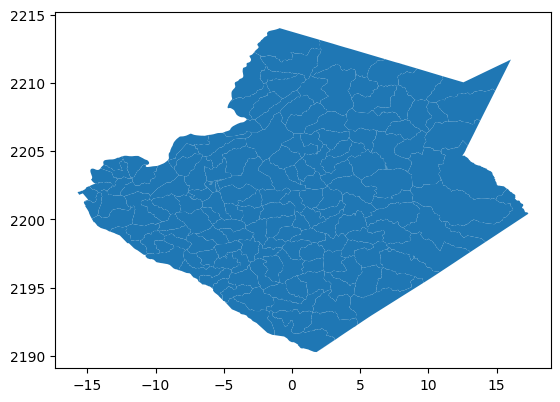

In [43]:
# Export/Importer
control_precincts = control_precincts.to_crs(crs = "EPSG:4326")
precinct_df_3.to_file("new_shapefile.shp")

test_import = gpd.read_file("/content/new_shapefile.shp")
test_import.plot()